# INSIGHT PROJECT - KC HOUSES

## Business Problem

Find the best properties to be renovated and maximize the company's profit.

1. Which properties should the company buy, and for what price?

2. Once bought, for what price should the company sell it?

## Business Understanding

House Rocket is a fictitious real estate business that adopts the flipping strategy. This strategy consists of buying properties that need repair, fixing, and selling them for profit. The House Rocket has a budget of 120 million dollars to invest in properties, and they would like to know which properties they should buy, and for what price to sell them.

### Solution Planning

1. Final Product
    - Table with the recommended properties to buy.

    - Table with the price to sell the properties.

    - Table with the financial results.

2. Tools
    - Python for data analysis.

    - IDE - VSCode.

    - Streamlit

3. Process
    - Data Analysis to find insights.

    - Validate some Hypothesis.

    - Build reports.

## Hypothesis

**H1**: Properties with waterfront are, on average, 20% more expensive.

**H2**: Properties built before 1965 are 50% cheaper, on average.

**H3**: Properties with basement are 30% more expensive. 

**H4**: Properties that weren't renovated are 25% cheaper.

**H5**: Constructions with 3 bathrooms have Month over Month growth of 15%.

**H6**: Properties with 3 or more bedrooms are 20% more expensive.

**H7**: Properties with low conditions <=2 are 45% cheaper.

**H8**: The price of the properties with 3 or more 3 bedrooms is increasing.

**H9**: Houses put on sale in the winter are cheaper.

## 1.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.utils import shuffle
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML
from IPython.display import Image
import datetime


In [2]:
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'

### 1.1. Helper Functions

In [3]:
# Box Plot
def b_plot(data, att, ax):
    sns.boxplot(y=data[att], ax=ax)
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title(f'{att.title()} BoxPlot');
    
# Box plot for 2 variables
def b_plot_cat(data, cat, target):
    plt.figure(figsize=(8,5))
    ax = sns.boxplot(x=cat, y=target, data=data)
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title(f'{cat.title()} x {target.title()} BoxPlot');
    plt.show()
    
# Outliers data
def outliers(data, feature):
    
    upper_ = np.percentile(data[feature], 98)
    mask = data[feature] >= upper_
    return data.loc[mask]
    
# Two variables comparison bar plot
def plot_bar(data, cat, cat_2):
    
    plot_data = data[[cat, cat_2]].groupby(cat).mean().reset_index()
    plot_data_2 = data[[cat, cat_2]].groupby(cat).median().reset_index()
    ylim = np.max([plot_data[cat_2].max(), plot_data_2[cat_2].max()])
    ylim = 0.05*ylim + ylim
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].bar(cat, cat_2, data=plot_data)
    axes[0].set_title(f'Average {cat_2.title()} per {cat.title()}')
    axes[0].ticklabel_format(style='plain', axis='y')
    axes[0].set_ylim(0, ylim)


    axes[1].bar(cat, cat_2, data=plot_data_2)
    axes[1].set_title(f'Median {cat_2.title()} per {cat.title()}')
    axes[1].ticklabel_format(style='plain', axis='y')
    axes[1].set_ylim(0, ylim)
    return None

def b_plot_cat(data, cat, target):
    
    ax = sns.boxplot(x=cat, y=target, data=data)
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title(f'{cat.title()} x {target.title()} BoxPlot');
    return None

# Feature Engineering
def condition(x):

    if x <= 2:
        return 'low'
    elif ((x >2 ) and (x <= 4)):
        return 'mid' 
    else:
        return 'high'

def note_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container {width: 100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

In [4]:
def find_comparables(id, aux_1):
    
    prop = aux_1.iloc[aux_1.query(f'id == {id}').index[0]]
    
    # id
    mask_id = aux_1['id'] != prop.id
    
    # Zipcode
    mask_zipcode = aux_1['zipcode'] == prop.zipcode
    
    # Waterfront
    mask_wfront = aux_1['waterfront'] == prop.waterfront

    # Condition Label
    mask_cond = aux_1['condition'] >= 3

    # Bathrooms
    mask_bath = (aux_1['bathrooms'] >= prop['bathrooms'] - 1) &  (aux_1['bathrooms'] <= prop['bathrooms'] + 1)

    # Floors
    mask_floors = (aux_1['floors'] >= prop['floors'] -1) &  (aux_1['floors'] <= prop['floors'] + 1)

    # Bedrooms
    mask_bedrooms = (aux_1['bedrooms'] >= prop['bedrooms'] -1) &  (aux_1['bedrooms'] <= prop['bedrooms'] + 1)

    # Year Built
    mask_year =  (aux_1['yr_built'] >= prop['yr_built'] - 15)  & (aux_1['yr_built'] <= prop['yr_built'] + 15)

    # Grade
    mask_grade =  (aux_1['grade'] >= prop.grade - 1) & (aux_1['grade'] <= prop.grade + 1)

    # mask_view = aux['view']
    mask_above =  (aux_1['m²_above'] >= prop['m²_above']*0.80)& (aux_1['m²_above'] <= prop['m²_above']*1.20)

    # Date
    mask_date = (aux_1['date'] >= prop.date - datetime.timedelta(days=90)) & (aux_1['date'] <= prop.date + datetime.timedelta(days=90))

    comps = aux_1.loc[mask_bath & mask_floors & mask_bedrooms & mask_zipcode & 
          mask_wfront & mask_cond & mask_year & mask_above & 
          mask_grade & mask_date & mask_id]

    if comps.shape[0] > 6:
        return comps.sample(6, random_state=0)
    else:
        return comps

In [5]:

def property_report(id, data):

    """Gets comparable properties and return the property price recommendation, expected costs and the after renovation cost.

    Parameters
    ----------
    comp : dataframe
        Dataframe with the comparable properties
    
    Returns
    -------
    A dictionary with price after renovation, recommended price to pay, expected rehab  cost, closing cost and profit
    """    

    prop = data.iloc[data.query(f'id == {id}').index[0]]
    comps = find_comparables(id, aux_1=data)
    
    # Average price of the comparables
    avg_comp_price2 = comps['price/m²'].mean()

    # After renovation price
    ARV = prop['m²_living'] * avg_comp_price2
    
    #Costs
    if (prop.condition == 3 and prop.grade >= 11) or prop.condition == 2:
        rehab_cost_per_sqrt_m = 398.26
    elif (prop.condition == 4 and prop.grade >= 10) or (prop.condition == 3 and prop.grade < 11):
        rehab_cost_per_sqrt_m = 279.86
    elif (prop.condition == 4 and prop.grade < 10):
        rehab_cost_per_sqrt_m = 150.69
    elif (prop.condition == 5):
        rehab_cost_per_sqrt_m = 75.34

    # Repair cost
    rehab_cost = rehab_cost_per_sqrt_m*prop['m²_living']

    # Recommended cost
    price_to_pay = 0.7*ARV - rehab_cost
    
    # Closing Costs
    closing_cost = 0.03*price_to_pay  # 3% of the purchase price

    
    values = pd.DataFrame({'id':id,'after_renovation_value': ARV, 'recom_price_to_pay': price_to_pay, 'rehab_cost': rehab_cost, 'closing_cost': closing_cost, 'comparables': comps.shape[0]}, index=[0])

    return values

In [6]:
note_settings()

### 1.2. Loading Data

In [7]:
data_raw = pd.read_csv('data/kc_house_data.csv')

In [8]:
data_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,3,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,3,6,770,0,1933,0,98028,47.738,-122.233,2720,8062
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,5,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,3,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 2.0. Data Description

In [9]:
df = data_raw.copy()

### 2.1. Data Dimensions

In [10]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 21613
Number of columns: 21


Há 21613 imóveis no conjunto de dados e cada um com 21 atributos.

### 2.2. Data Types

In [11]:
# Convertendo data para datetime64
df['date'] = pd.to_datetime(df['date'])
# Converting square ft to square meters.
dim = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df[dim] = df[dim].apply(lambda x: round(x*0.092903, 2))


for i in range(len(dim)):   
    df.rename(columns={dim[i]: dim[i].replace('sqft', 'm²')}, inplace=True)
df.dtypes


id                       int64
date            datetime64[ns]
price                  float64
bedrooms                 int64
bathrooms              float64
m²_living              float64
m²_lot                 float64
floors                 float64
waterfront               int64
view                     int64
condition                int64
grade                    int64
m²_above               float64
m²_basement            float64
yr_built                 int64
yr_renovated             int64
zipcode                  int64
lat                    float64
long                   float64
m²_living15            float64
m²_lot15               float64
dtype: object

### 2.3. Check NA

In [12]:
df.isnull().sum()

id              0
date            0
price           0
bedrooms        0
bathrooms       0
m²_living       0
m²_lot          0
floors          0
waterfront      0
view            0
condition       0
grade           0
m²_above        0
m²_basement     0
yr_built        0
yr_renovated    0
zipcode         0
lat             0
long            0
m²_living15     0
m²_lot15        0
dtype: int64

### 2.4. Duplicates

In [13]:
# Checking duplicates on the dataset
df.duplicated().sum()

0

In [14]:
# Checking duplicated id
df['id'].duplicated().sum()

177

#### 2.4.1. Removing Duplicated houses

In [15]:
df_unique = df.drop_duplicates('id', keep='first')

### 2.5.  Feature Engineering

In [16]:
# Renovation
df_unique['renovated'] = df_unique['yr_renovated'].apply(lambda x: 'yes' if x != 0 else 'no')

# Construction
df_unique['construction'] = df_unique['yr_built'].apply(lambda x: '<1965' if x < 1965 else '>1965')

# 3_or more_bedrooms
df_unique['3_or_more_bedrooms'] = df_unique['bedrooms'].apply(lambda x: '3+' if x >=3 else '<3')

# Basement
df_unique['basement'] = df_unique['m²_basement'].apply(lambda x: 'yes' if x != 0 else 'no')

# Waterfront
df_unique['waterfront'] = df_unique['waterfront'].apply(lambda x: 'no' if x == 0 else 'yes')

# Condition
df_unique['condition_label'] = df_unique['condition'].apply(condition)

# price/m²
df_unique['price/m²'] = df_unique['price']/df_unique['m²_living']

# Seasons

# Summer
df_unique.loc[(df_unique['date'].dt.strftime('%m-%d') >= '06-21') & (df_unique['date'].dt.strftime('%m-%d') <= '09-22'), 'season'] = 'summer'

# Autumn
df_unique.loc[(df_unique['date'].dt.strftime('%m-%d') >= '09-23') & (df_unique['date'].dt.strftime('%m-%d') <= '12-20'), 'season'] = 'autumn'

# Winter
mask_1 = (df_unique['date'].dt.strftime('%m-%d') >= '12-21') & (df_unique['date'].dt.strftime('%m-%d') <= '12-31')

mask_2 = (df_unique['date'].dt.strftime('%m-%d') >= '01-01') & (df_unique['date'].dt.strftime('%m-%d') <= '03-20')

df_unique.loc[(mask_1 | mask_2) , 'season'] = 'winter'

# Spring
df_unique.loc[(df_unique['date'].dt.strftime('%m-%d') >= '03-21') & (df_unique['date'].dt.strftime('%m-%d') <= '06-20'), 'season'] = 'spring'

In [17]:
df_unique.dtypes

id                             int64
date                  datetime64[ns]
price                        float64
bedrooms                       int64
bathrooms                    float64
m²_living                    float64
m²_lot                       float64
floors                       float64
waterfront                    object
view                           int64
condition                      int64
grade                          int64
m²_above                     float64
m²_basement                  float64
yr_built                       int64
yr_renovated                   int64
zipcode                        int64
lat                          float64
long                         float64
m²_living15                  float64
m²_lot15                     float64
renovated                     object
construction                  object
3_or_more_bedrooms            object
basement                      object
condition_label               object
price/m²                     float64
s

### 2.6 Descriptive statistics

#### 2.6.1 Numerical Attributes

In [18]:
num_att = df.select_dtypes(include=['float64', 'int64'])

In [19]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1000102.000,9900000190.000,9899000088.000,4580301520.865,3904930410.000,2876565571.312,0.243,-1.261
1,price,75000.000,7700000.000,7625000.000,540088.142,450000.000,367127.196,4.024,34.586
2,bedrooms,0.000,33.000,33.000,3.371,3.000,0.930,1.974,49.064
3,bathrooms,0.000,8.000,8.000,2.115,2.250,0.770,0.511,1.280
4,m²_living,26.940,1257.910,1230.970,193.229,177.440,85.326,1.472,5.243
5,m²_lot,48.310,153416.210,153367.900,1403.483,707.740,3848.090,13.060,285.078
6,floors,1.000,3.500,2.500,1.494,1.500,0.540,0.616,-0.485
7,waterfront,0.000,1.000,1.000,0.008,0.000,0.087,11.385,127.632
8,view,0.000,4.000,4.000,0.234,0.000,0.766,3.396,10.893
9,condition,1.000,5.000,4.000,3.409,3.000,0.651,1.033,0.526


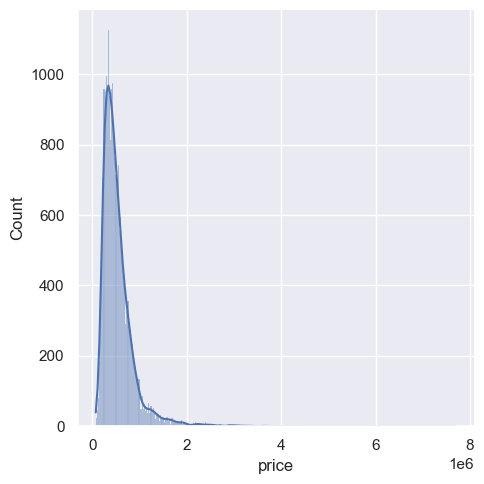

In [20]:
sns.displot(df_unique['price'], kde=True,);

#### 2.6.2 Outliers

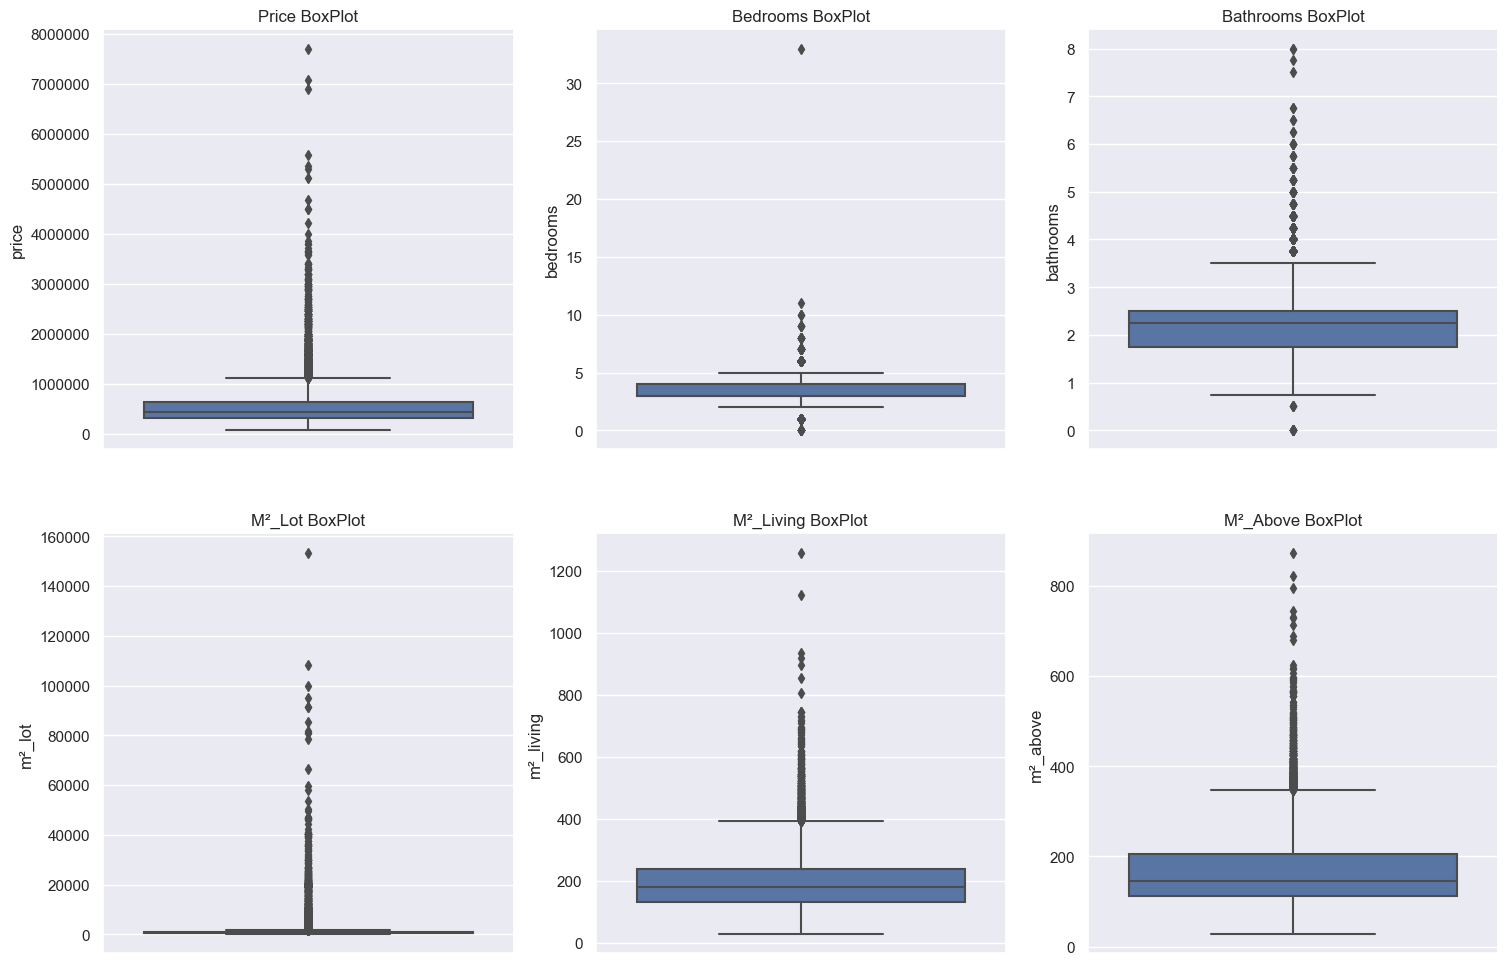

In [21]:
fig, axis = plt.subplots(2, 3, figsize=(18, 12))
b_plot(df_unique, 'price', ax=axis[0][0])
b_plot(df_unique, 'bedrooms', ax=axis[0][1])
b_plot(df_unique, 'bathrooms', ax=axis[0][2])
b_plot(df_unique, 'm²_lot', ax=axis[1][0])
b_plot(df_unique, 'm²_living', ax=axis[1][1])
b_plot(df_unique, 'm²_above', ax=axis[1][2])

There are some some properties that have less than one bathrooms, and some that have 0 bedrooms. These properties will be removed, since they don't make sense for the businesss. 

##### Price

In [22]:
outliers(df_unique, 'price').sort_values('price', ascending=False).head(10)

,id,date,price,bedrooms,bathrooms,m²_living,m²_lot,floors,waterfront,view,condition,grade,m²_above,m²_basement,yr_built,yr_renovated,zipcode,lat,long,m²_living15,m²_lot15,renovated,construction,3_or_more_bedrooms,basement,condition_label,price/m²,season
7252,6762700020,2014-10-13,7700000.000,6,8.000,1119.480,2564.120,2.500,no,3,4,13,796.180,323.300,1910,1987,98102,47.630,-122.323,366.040,817.550,yes,<1965,3+,yes,mid,6878.193,autumn
3914,9808700762,2014-06-11,7062500.000,5,4.500,932.750,3467.600,2.000,yes,2,3,11,713.500,219.250,1940,2001,98004,47.650,-122.214,365.110,2364.290,yes,<1965,3+,yes,mid,7571.697,spring
9254,9208900037,2014-09-19,6885000.000,6,7.750,918.810,2914.740,2.000,no,4,3,13,823.120,95.690,2001,0,98039,47.630,-122.240,421.780,3969.750,no,>1965,3+,yes,mid,7493.388,summer
4411,2470100110,2014-08-04,5570000.000,5,5.750,854.710,3258.020,2.000,no,0,3,13,576.000,278.710,2001,0,98039,47.629,-122.233,330.730,2261.720,no,>1965,3+,yes,mid,6516.830,summer
1448,8907500070,2015-04-13,5350000.000,5,5.000,743.220,2228.280,2.000,no,4,3,12,624.310,118.920,2009,0,98004,47.623,-122.220,427.350,2020.640,no,>1965,3+,yes,mid,7198.407,spring
1315,7558700030,2015-04-13,5300000.000,6,6.000,686.550,2306.690,2.000,yes,4,4,12,464.520,222.040,1991,0,98040,47.563,-122.210,401.340,2287.180,no,>1965,3+,yes,mid,7719.758,spring
1164,1247600105,2014-10-20,5110800.000,5,5.250,744.150,4228.670,2.000,yes,4,3,12,556.490,187.660,1999,0,98033,47.677,-122.211,318.660,2488.690,no,>1965,3+,yes,mid,6867.970,autumn
8092,1924059029,2014-06-17,4668000.000,5,6.750,895.580,1214.060,1.000,yes,4,3,12,447.790,447.790,1983,2009,98040,47.557,-122.210,303.790,971.210,yes,>1965,3+,yes,mid,5212.265,spring
2626,7738500731,2014-08-15,4500000.000,5,5.500,616.880,3717.420,2.000,yes,4,3,12,589.930,26.940,2004,0,98155,47.749,-122.280,281.500,2174.670,no,>1965,3+,yes,mid,7294.774,summer
8638,3835500195,2014-06-18,4489000.000,4,3.000,597.370,2556.410,2.000,no,0,3,12,597.370,0.000,2001,0,98004,47.621,-122.219,345.600,1355.640,no,>1965,3+,no,mid,7514.606,spring


There are some really high prices, but they aren't absurd for the size, condtion and grade of the property.

##### Bedrooms

In [23]:
outliers(df_unique, 'bedrooms').sort_values('bedrooms', ascending=False).head(10)

,id,date,price,bedrooms,bathrooms,m²_living,m²_lot,floors,waterfront,view,condition,grade,m²_above,m²_basement,yr_built,yr_renovated,zipcode,lat,long,m²_living15,m²_lot15,renovated,construction,3_or_more_bedrooms,basement,condition_label,price/m²,season
15870,2402100895,2014-06-25,640000.000,33,1.750,150.500,557.420,1.000,no,0,5,7,96.620,53.880,1947,0,98103,47.688,-122.331,123.560,436.640,no,<1965,3+,yes,high,4252.492,summer
8757,1773100755,2014-08-21,520000.000,11,3.000,278.710,460.800,2.000,no,0,3,7,222.970,55.740,1918,1999,98106,47.556,-122.363,131.920,460.800,yes,<1965,3+,yes,mid,1865.739,summer
19254,8812401450,2014-12-29,660000.000,10,3.000,271.280,347.920,2.000,no,0,4,7,172.800,98.480,1913,0,98105,47.663,-122.320,168.150,347.920,no,<1965,3+,yes,mid,2432.911,winter
13314,627300145,2014-08-14,1148000.000,10,5.250,426.420,1014.500,1.000,no,2,3,9,232.260,194.170,2008,0,98004,47.586,-122.113,253.630,966.190,no,>1965,3+,yes,mid,2692.181,summer
15161,5566100170,2014-10-29,650000.000,10,2.000,335.380,1106.850,2.000,no,0,4,7,279.640,55.740,1958,0,98006,47.571,-122.175,189.520,1106.850,no,<1965,3+,yes,mid,1938.100,autumn
18443,8823901445,2015-03-13,934000.000,9,3.000,261.990,416.210,2.000,no,0,3,7,174.660,87.330,1918,0,98105,47.665,-122.307,228.540,408.770,no,<1965,3+,yes,mid,3565.022,winter
4096,1997200215,2014-05-07,599999.000,9,4.500,355.820,649.210,2.500,no,0,3,7,227.610,128.210,1938,0,98103,47.693,-122.338,135.640,584.450,no,<1965,3+,yes,mid,1686.243,spring
4235,2902200015,2015-01-06,700000.000,9,3.000,341.880,408.770,2.000,no,0,3,7,262.920,78.970,1908,0,98102,47.637,-122.324,182.090,227.610,no,<1965,3+,yes,mid,2047.502,winter
6079,9822700190,2014-08-08,1280000.000,9,4.500,339.100,464.520,2.000,no,0,3,8,235.040,104.050,1915,2010,98105,47.660,-122.289,233.190,464.520,yes,<1965,3+,yes,mid,3774.698,summer
8546,424049043,2014-08-11,450000.000,9,7.500,376.260,604.240,2.000,no,0,3,7,376.260,0.000,1996,0,98144,47.592,-122.301,134.520,359.160,no,>1965,3+,no,mid,1195.982,summer


A house with 33 bedroom is really strange, it must be a typo. Especially if you consider that the living area is only 150.5 m², so this property will be removed from the dataset.

##### M²_Lot

In [24]:
outliers(df_unique, 'm²_lot').sort_values('m²_lot', ascending=False).head(10)

,id,date,price,bedrooms,bathrooms,m²_living,m²_lot,floors,waterfront,view,condition,grade,m²_above,m²_basement,yr_built,yr_renovated,zipcode,lat,long,m²_living15,m²_lot15,renovated,construction,3_or_more_bedrooms,basement,condition_label,price/m²,season
1719,1020069017,2015-03-27,700000.000,4,1.000,120.770,153416.210,1.000,no,3,4,6,120.770,0.000,1920,0,98022,47.231,-122.023,237.830,39537.750,no,<1965,3+,no,mid,5796.141,spring
17319,3326079016,2015-05-04,190000.000,2,1.000,65.960,108212.860,1.000,no,0,2,5,65.960,0.000,1915,0,98014,47.689,-121.909,156.080,1554.270,no,<1965,<3,no,low,2880.534,spring
7647,2623069031,2014-05-21,542500.000,5,3.250,279.640,99798.070,1.500,no,0,5,8,186.740,92.900,1931,0,98027,47.456,-122.004,227.610,6394.050,no,<1965,3+,yes,high,1939.994,spring
7769,2323089009,2015-01-19,855000.000,4,3.500,374.400,95138.990,2.000,no,0,3,10,374.400,0.000,2006,0,98045,47.462,-121.744,170.010,1086.970,no,>1965,3+,no,mid,2283.654,winter
3949,722069232,2014-09-05,998000.000,4,3.250,350.240,91323.460,2.000,no,0,3,10,350.240,0.000,1992,0,98058,47.414,-122.087,212.750,3450.510,no,>1965,3+,no,mid,2849.475,summer
4441,3626079040,2014-07-30,790000.000,2,3.000,237.830,91256.570,1.000,no,0,3,8,237.830,0.000,2004,0,98014,47.696,-121.861,150.500,3804.010,no,>1965,<3,no,mid,3321.700,summer
6691,2624089007,2015-03-20,1998000.000,2,2.500,362.320,85510.060,2.000,no,0,3,12,362.320,0.000,2009,0,98065,47.537,-121.756,252.700,38272.510,no,>1965,<3,no,mid,5514.462,winter
7077,2724079090,2015-01-05,1650000.000,4,3.250,364.180,81908.300,3.000,no,3,3,11,364.180,0.000,2002,0,98024,47.538,-121.896,275.920,10440.810,no,>1965,3+,no,mid,4530.727,winter
9714,225079036,2015-01-07,937500.000,4,4.000,515.150,80937.090,2.000,no,0,3,11,334.920,180.230,2003,0,98014,47.676,-121.882,317.730,80937.090,no,>1965,3+,yes,mid,1819.858,winter
20452,1125079111,2015-04-15,1600000.000,4,5.500,606.660,80937.090,2.000,no,2,3,11,606.660,0.000,2008,0,98014,47.664,-121.878,118.920,79723.040,no,>1965,3+,no,mid,2637.392,spring


There are some lots with really high areas, but nothing absurd because they are in more remote areas. And although the top 3 seems too high for their prices, the buildings are old and were never renovated.

##### M²_Living

In [25]:
outliers(df_unique, 'm²_living').sort_values('m²_living', ascending=False).head(10)

,id,date,price,bedrooms,bathrooms,m²_living,m²_lot,floors,waterfront,view,condition,grade,m²_above,m²_basement,yr_built,yr_renovated,zipcode,lat,long,m²_living15,m²_lot15,renovated,construction,3_or_more_bedrooms,basement,condition_label,price/m²,season
12777,1225069038,2014-05-05,2280000.000,7,8.000,1257.910,28591.080,3.000,no,4,3,12,874.220,383.690,1999,0,98053,47.667,-121.986,450.580,20234.270,no,>1965,3+,yes,mid,1812.530,spring
7252,6762700020,2014-10-13,7700000.000,6,8.000,1119.480,2564.120,2.500,no,3,4,13,796.180,323.300,1910,1987,98102,47.630,-122.323,366.040,817.550,yes,<1965,3+,yes,mid,6878.193,autumn
3914,9808700762,2014-06-11,7062500.000,5,4.500,932.750,3467.600,2.000,yes,2,3,11,713.500,219.250,1940,2001,98004,47.650,-122.214,365.110,2364.290,yes,<1965,3+,yes,mid,7571.697,spring
9254,9208900037,2014-09-19,6885000.000,6,7.750,918.810,2914.740,2.000,no,4,3,13,823.120,95.690,2001,0,98039,47.630,-122.240,421.780,3969.750,no,>1965,3+,yes,mid,7493.388,summer
8092,1924059029,2014-06-17,4668000.000,5,6.750,895.580,1214.060,1.000,yes,4,3,12,447.790,447.790,1983,2009,98040,47.557,-122.210,303.790,971.210,yes,>1965,3+,yes,mid,5212.265,spring
4411,2470100110,2014-08-04,5570000.000,5,5.750,854.710,3258.020,2.000,no,0,3,13,576.000,278.710,2001,0,98039,47.629,-122.233,330.730,2261.720,no,>1965,3+,yes,mid,6516.830,summer
14556,2303900035,2014-06-11,2888000.000,5,6.250,805.470,5948.860,2.000,no,4,3,13,568.570,236.900,1965,2003,98177,47.730,-122.372,384.620,7527.090,yes,>1965,3+,yes,mid,3585.484,spring
18302,6072800246,2014-07-02,3300000.000,5,6.250,745.080,2019.530,2.000,no,0,3,11,745.080,0.000,2001,0,98006,47.568,-122.189,386.480,1762.280,no,>1965,3+,no,mid,4429.055,summer
1164,1247600105,2014-10-20,5110800.000,5,5.250,744.150,4228.670,2.000,yes,4,3,12,556.490,187.660,1999,0,98033,47.677,-122.211,318.660,2488.690,no,>1965,3+,yes,mid,6867.970,autumn
1448,8907500070,2015-04-13,5350000.000,5,5.000,743.220,2228.280,2.000,no,4,3,12,624.310,118.920,2009,0,98004,47.623,-122.220,427.350,2020.640,no,>1965,3+,yes,mid,7198.407,spring


##### M²_Above

In [26]:
outliers(df_unique, 'm²_above').sort_values('m²_above', ascending=False).head(10)

,id,date,price,bedrooms,bathrooms,m²_living,m²_lot,floors,waterfront,view,condition,grade,m²_above,m²_basement,yr_built,yr_renovated,zipcode,lat,long,m²_living15,m²_lot15,renovated,construction,3_or_more_bedrooms,basement,condition_label,price/m²,season
12777,1225069038,2014-05-05,2280000.000,7,8.000,1257.910,28591.080,3.000,no,4,3,12,874.220,383.690,1999,0,98053,47.667,-121.986,450.580,20234.270,no,>1965,3+,yes,mid,1812.530,spring
9254,9208900037,2014-09-19,6885000.000,6,7.750,918.810,2914.740,2.000,no,4,3,13,823.120,95.690,2001,0,98039,47.630,-122.240,421.780,3969.750,no,>1965,3+,yes,mid,7493.388,summer
7252,6762700020,2014-10-13,7700000.000,6,8.000,1119.480,2564.120,2.500,no,3,4,13,796.180,323.300,1910,1987,98102,47.630,-122.323,366.040,817.550,yes,<1965,3+,yes,mid,6878.193,autumn
18302,6072800246,2014-07-02,3300000.000,5,6.250,745.080,2019.530,2.000,no,0,3,11,745.080,0.000,2001,0,98006,47.568,-122.189,386.480,1762.280,no,>1965,3+,no,mid,4429.055,summer
13411,2426039123,2015-01-30,2415000.000,5,4.750,732.080,2252.900,2.000,no,2,3,13,732.080,0.000,1996,0,98177,47.733,-122.362,254.550,999.730,no,>1965,3+,no,mid,3298.820,winter
19858,2524069078,2015-01-22,2700000.000,4,4.000,729.290,8328.850,2.000,no,0,3,12,729.290,0.000,2006,0,98027,47.541,-121.982,576.930,8903.080,no,>1965,3+,no,mid,3702.231,winter
3914,9808700762,2014-06-11,7062500.000,5,4.500,932.750,3467.600,2.000,yes,2,3,11,713.500,219.250,1940,2001,98004,47.650,-122.214,365.110,2364.290,yes,<1965,3+,yes,mid,7571.697,spring
11871,8835800350,2015-01-12,1950000.000,4,3.250,689.340,15595.530,2.000,no,3,3,12,689.340,0.000,2002,0,98045,47.455,-121.764,521.190,15751.610,no,>1965,3+,no,mid,2828.793,winter
18594,3023069166,2014-07-08,1135250.000,5,4.000,680.050,20234.270,2.000,no,0,3,11,680.050,0.000,1992,0,98058,47.447,-122.086,303.790,3205.150,no,>1965,3+,no,mid,1669.363,summer
1448,8907500070,2015-04-13,5350000.000,5,5.000,743.220,2228.280,2.000,no,4,3,12,624.310,118.920,2009,0,98004,47.623,-122.220,427.350,2020.640,no,>1965,3+,yes,mid,7198.407,spring


The other attributes don't have values that doesn't make sense.

#### 2.6.4 Categorical Attributes

<Figure size 2500x1200 with 0 Axes>

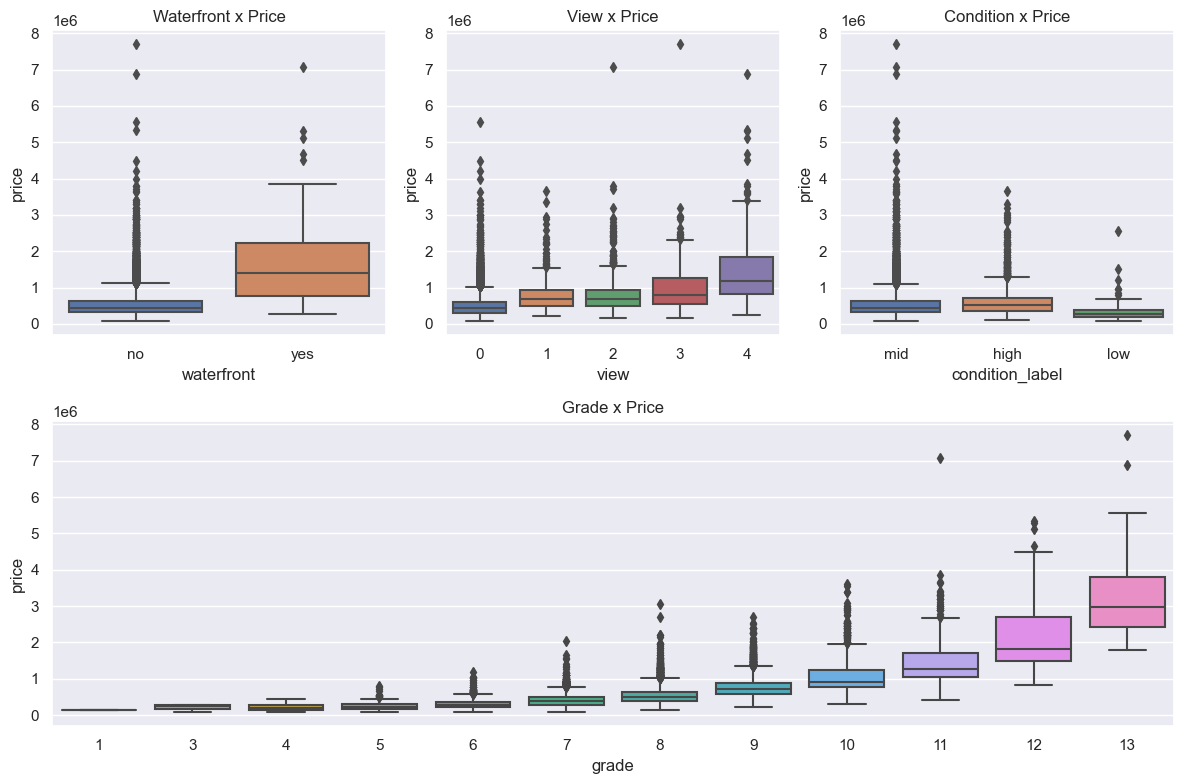

In [27]:
grid = GridSpec(2, 3)

# Waterfront
plt.tight_layout()
plt.figure(figsize=(12, 8))
plt.subplot(grid[0, 0])
sns.boxplot(x='waterfront', y='price', data=df_unique)
plt.title('Waterfront x Price')

# View               
plt.subplot(grid[0, 1])
sns.boxplot(x='view', y='price', data=df_unique)
plt.title('View x Price')

# Condition          
plt.subplot(grid[0, 2])
sns.boxplot(x='condition_label', y='price', data=df_unique)
plt.title('Condition x Price')

# Grade              
plt.subplot(grid[1, :])
sns.boxplot(x='grade', y='price', data=df_unique)
plt.title('Grade x Price')
plt.tight_layout()
plt.show()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 3.0. Filtering Variables

In [28]:
# Removing Outliers
df_unique = df_unique.loc[df_unique['bedrooms'] != max(df_unique['bedrooms'])]
df_unique = df_unique.loc[(df_unique.bedrooms > 0) & (df_unique.bathrooms > 0)]

# Removing houses with les than 75m²
df_unique = df_unique.loc[(df_unique['m²_living'] > 75)]

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 4.0. Exploratory Analysis

#### 4.1. Numerical

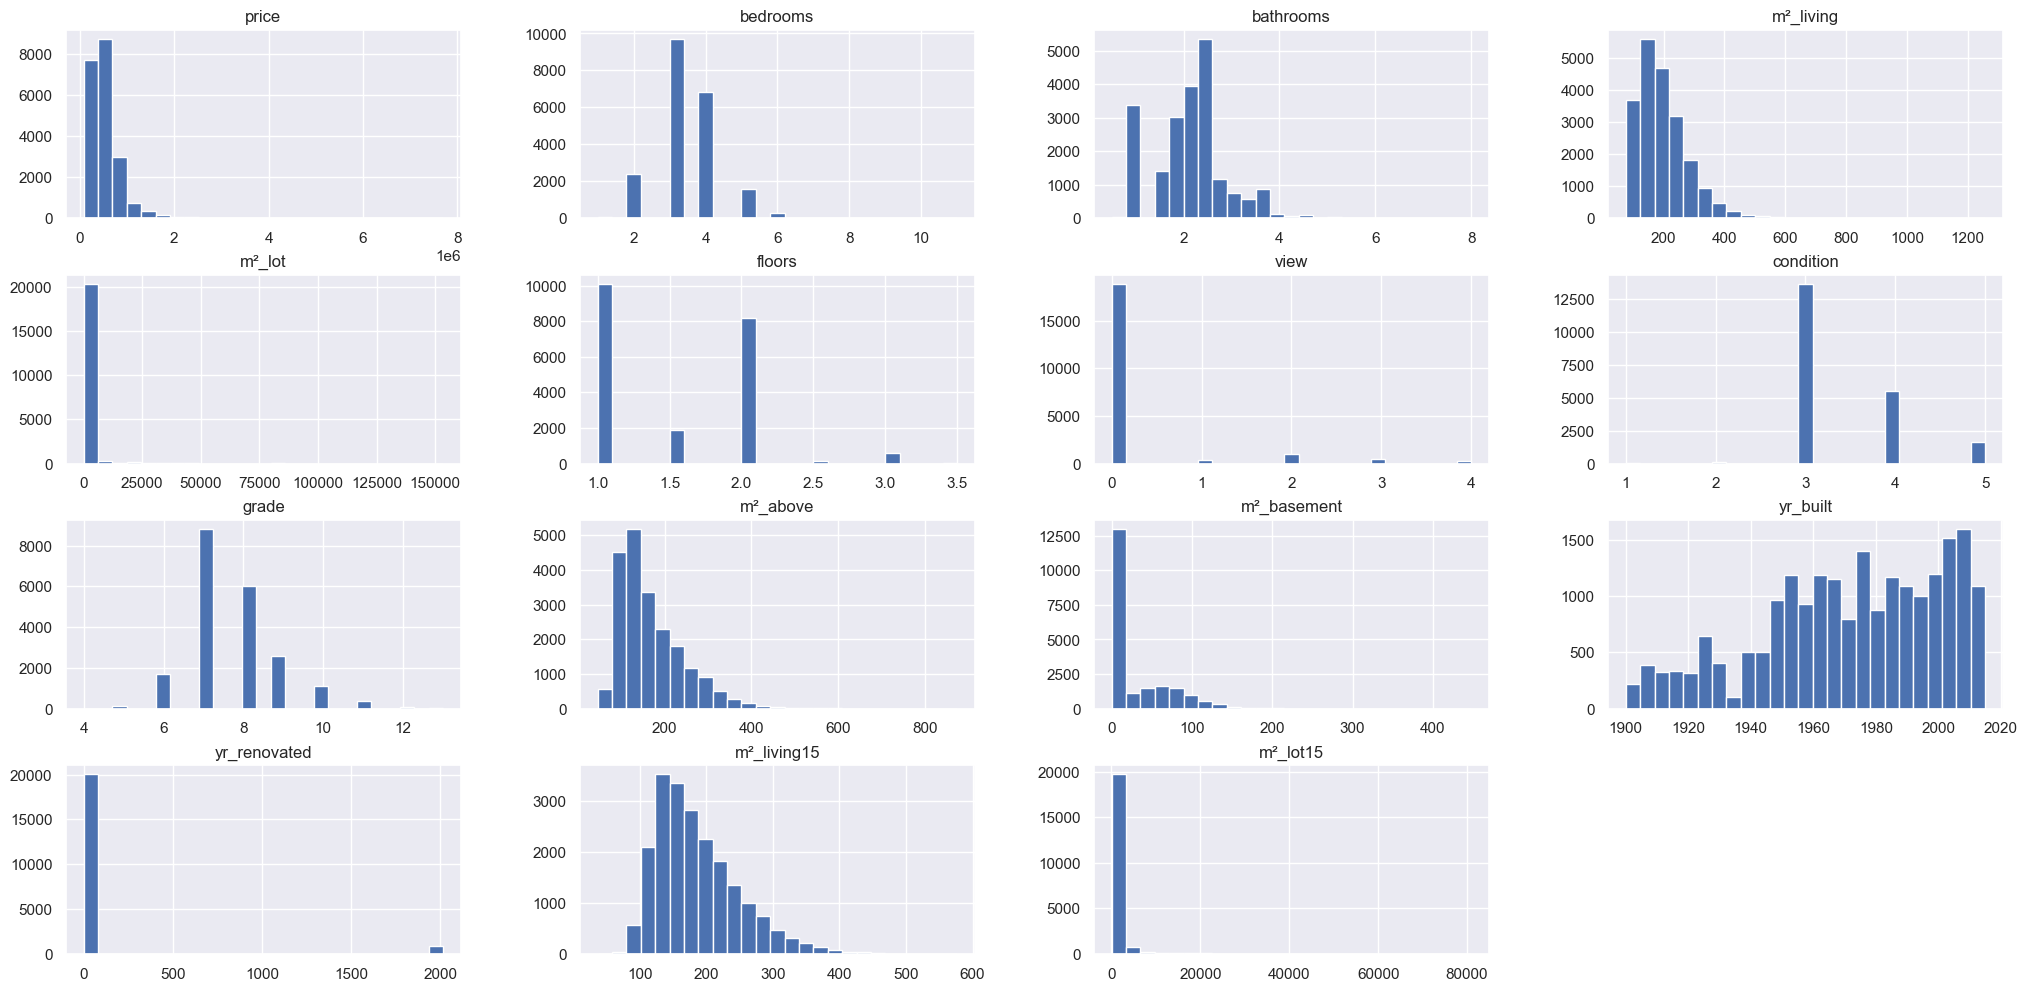

In [29]:
numeric = ['price', 'bedrooms', 'bathrooms', 'm²_living', 'm²_lot', 'floors', 'view', 'condition', 'grade', 'm²_above', 'm²_basement', 'yr_built', 'yr_renovated', 'm²_living15', 'm²_lot15']

df_plot_num = df_unique[numeric]

df_plot_num.hist(bins=25);

#### 4.2. Categorical Variables

In [30]:
df_cat = df_unique.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

<AxesSubplot: xlabel='construction', ylabel='price'>

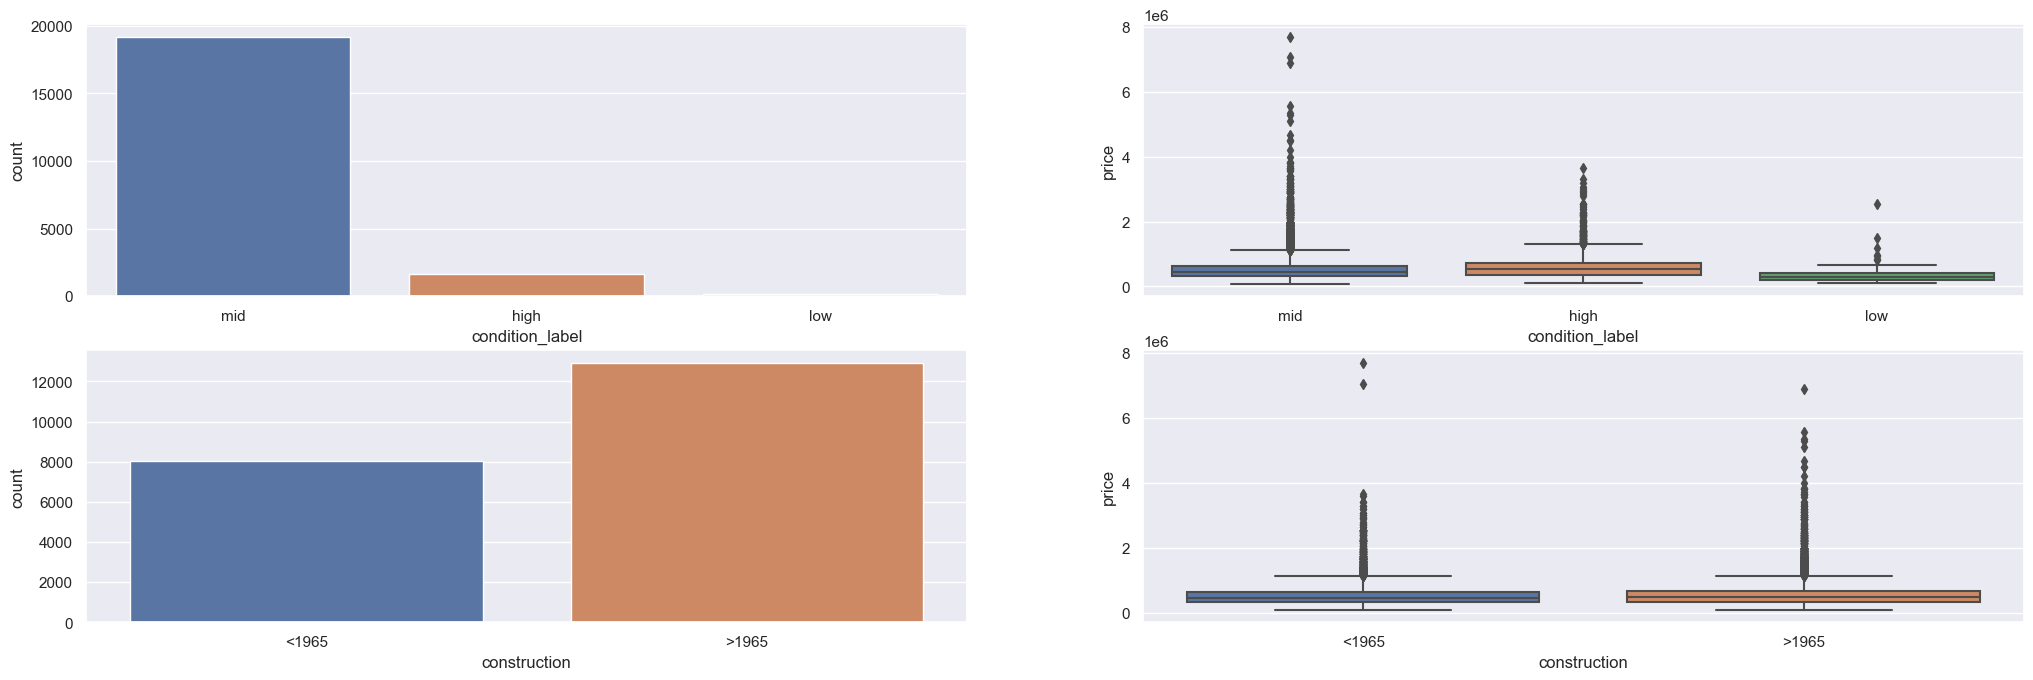

In [31]:
# waterfront
plt.subplot(3, 2, 1)
sns.countplot(x=df_unique['condition_label'])
plt.subplot(3, 2, 2)
sns.boxplot(data=df_unique, x='condition_label', y='price')

# renovated'
plt.subplot(3, 2, 3)
sns.countplot(x=df_unique['construction'])
plt.subplot(3, 2, 4)
sns.boxplot(data=df_unique, x='construction', y='price')

- The variability on the price due to the condition is not high, but we can see that the properties with a consition lower than 3 have a lower price when compared to the others.

- The grade has a huge impact on the price. As the grade get higher the price increases.

- The quality of the view has some impact on the price of the property.


<AxesSubplot: xlabel='construction', ylabel='price'>

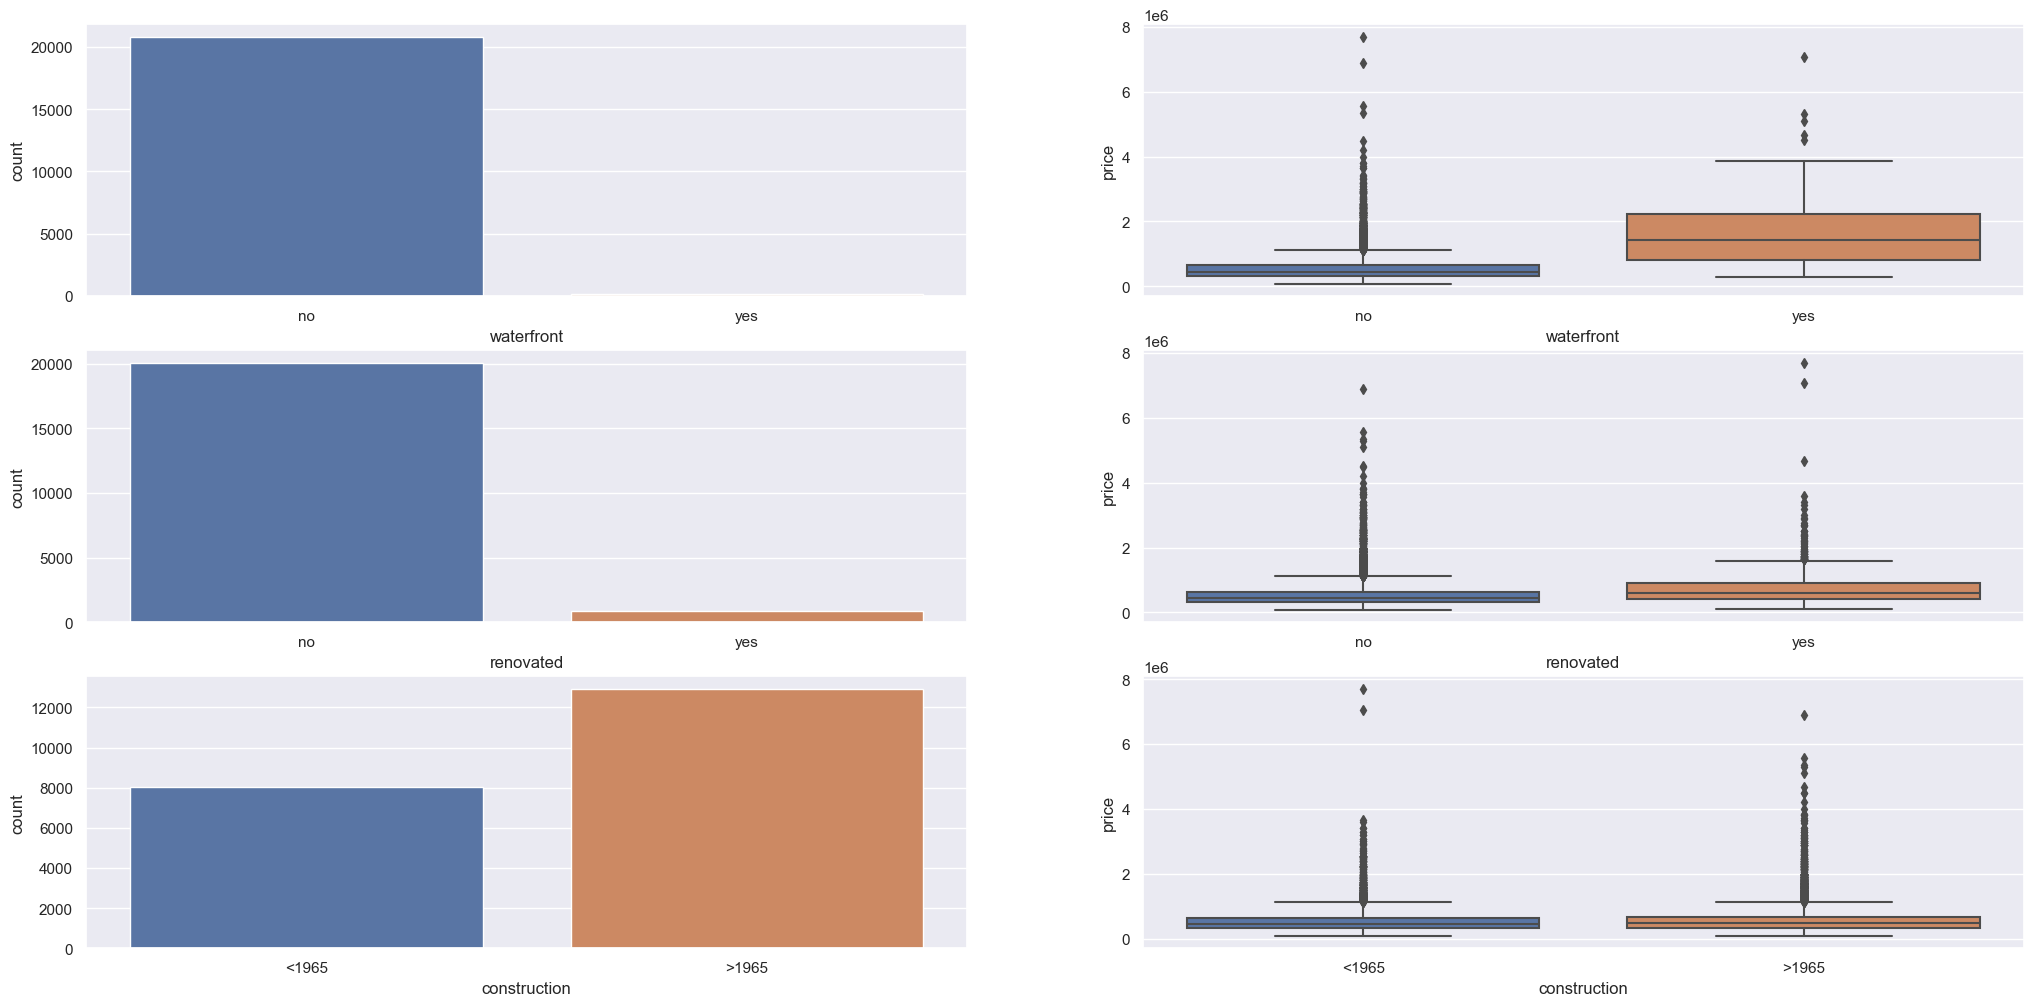

In [32]:
# waterfront
plt.subplot(3, 2, 1)
sns.countplot(x=df_unique['waterfront'])
plt.subplot(3, 2, 2)
sns.boxplot(data=df_unique, x='waterfront', y='price')

# renovated'
plt.subplot(3, 2, 3)
sns.countplot(x=df_unique['renovated'])
plt.subplot(3, 2, 4)
sns.boxplot(data=df_unique, x='renovated', y='price')

#b_plot_cat(data=data, cat='construction', target='price')
# construction
plt.subplot(3, 2, 5)
sns.countplot(x=df_unique['construction'])
plt.subplot(3, 2, 6)
sns.boxplot(data=df_unique, x='construction', y='price')

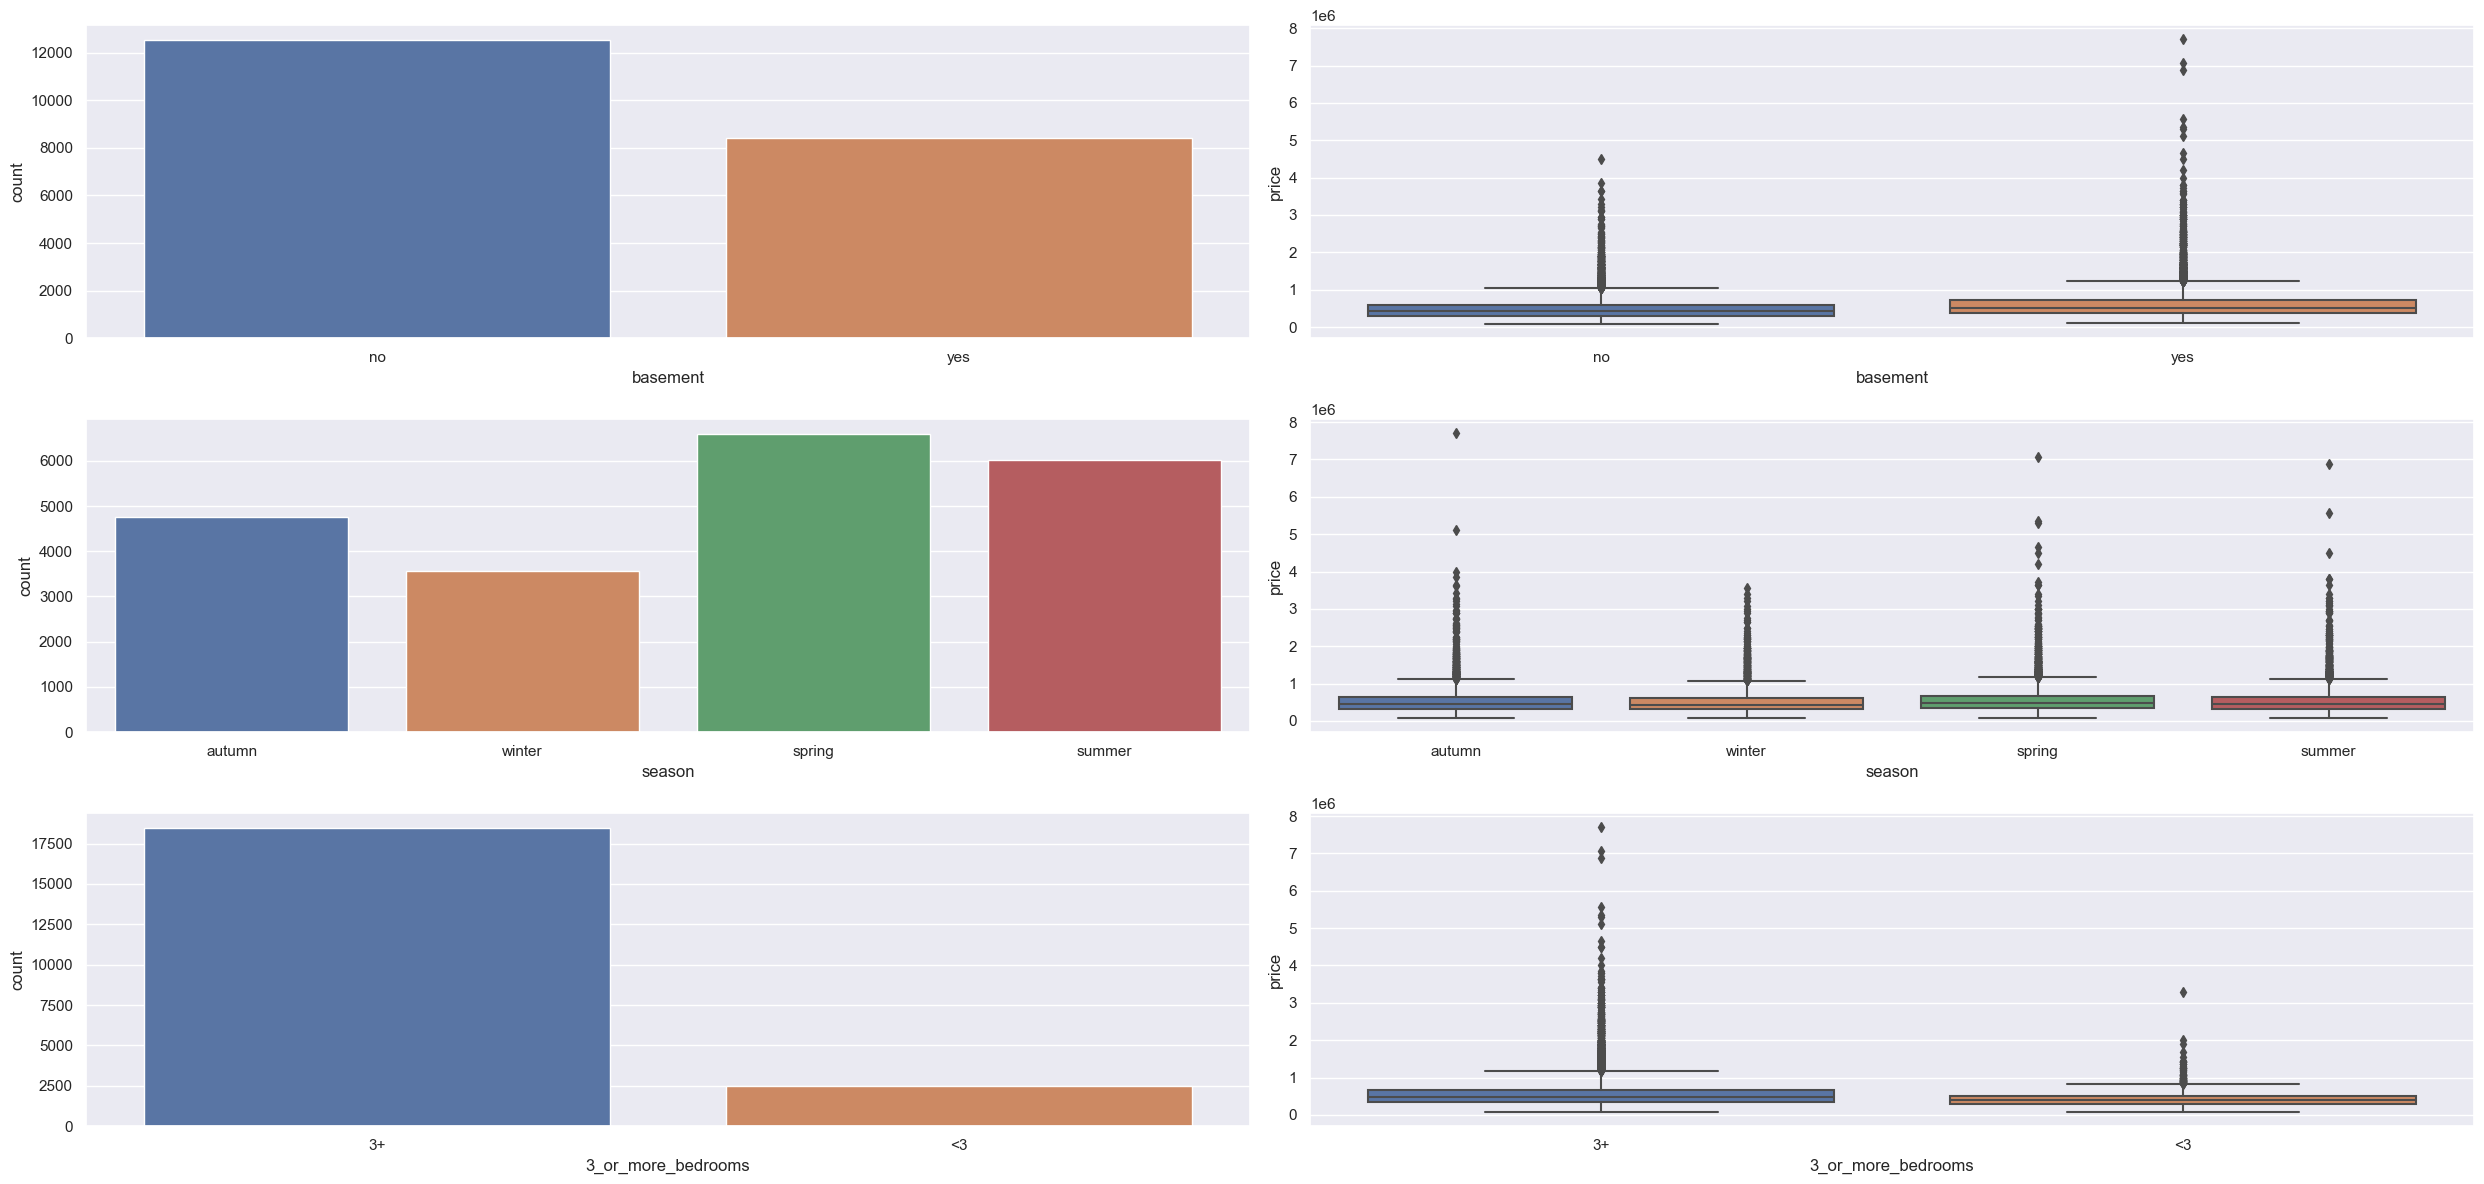

In [33]:
# basement
plt.subplot(3, 2, 1)
sns.countplot(x=df_unique['basement'])
plt.subplot(3, 2, 2)
sns.boxplot(data=df_unique, x='basement', y='price')

# season
plt.subplot(3, 2, 3)
sns.countplot(x=df_unique['season'])
plt.subplot(3, 2, 4)
sns.boxplot(data=df_unique, x='season', y='price')

# 3_or_more_bedrooms
plt.subplot(3, 2, 5)
sns.countplot(x=df_unique['3_or_more_bedrooms'])
plt.subplot(3, 2, 6)
sns.boxplot(data=df_unique, x='3_or_more_bedrooms', y='price')
plt.tight_layout()

- Having a waterfront seems to be a big factor in the price of the property.

- The age, and whether the construction was renovated or not don't have much impact on the price.

- Having a basement doesn't seem to have a impact on the variability of the property's price.

- There is not much variability in the price due to the season.

In [34]:
df_unique.head()

,id,date,price,bedrooms,bathrooms,m²_living,m²_lot,floors,waterfront,view,condition,grade,m²_above,m²_basement,yr_built,yr_renovated,zipcode,lat,long,m²_living15,m²_lot15,renovated,construction,3_or_more_bedrooms,basement,condition_label,price/m²,season
0,7129300520,2014-10-13,221900.000,3,1.000,109.630,524.900,1.000,no,0,3,7,109.630,0.000,1955,0,98178,47.511,-122.257,124.490,524.900,no,<1965,3+,no,mid,2024.081,autumn
1,6414100192,2014-12-09,538000.000,3,2.250,238.760,672.800,2.000,no,0,3,7,201.600,37.160,1951,1991,98125,47.721,-122.319,157.010,709.690,yes,<1965,3+,yes,mid,2253.309,autumn
3,2487200875,2014-12-09,604000.000,4,3.000,182.090,464.520,1.000,no,0,5,7,97.550,84.540,1965,0,98136,47.521,-122.393,126.350,464.520,no,>1965,3+,yes,high,3317.041,autumn
4,1954400510,2015-02-18,510000.000,3,2.000,156.080,750.660,1.000,no,0,3,8,156.080,0.000,1987,0,98074,47.617,-122.045,167.230,697.050,no,>1965,3+,no,mid,3267.555,winter
5,7237550310,2014-05-12,1225000.000,4,4.500,503.530,9469.600,1.000,no,0,3,11,361.390,142.140,2001,0,98053,47.656,-122.005,442.220,9469.600,no,>1965,3+,yes,mid,2432.824,spring


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 5.0. Insights

**H1**: Properties with waterfront are, on average, 20% more expensive.

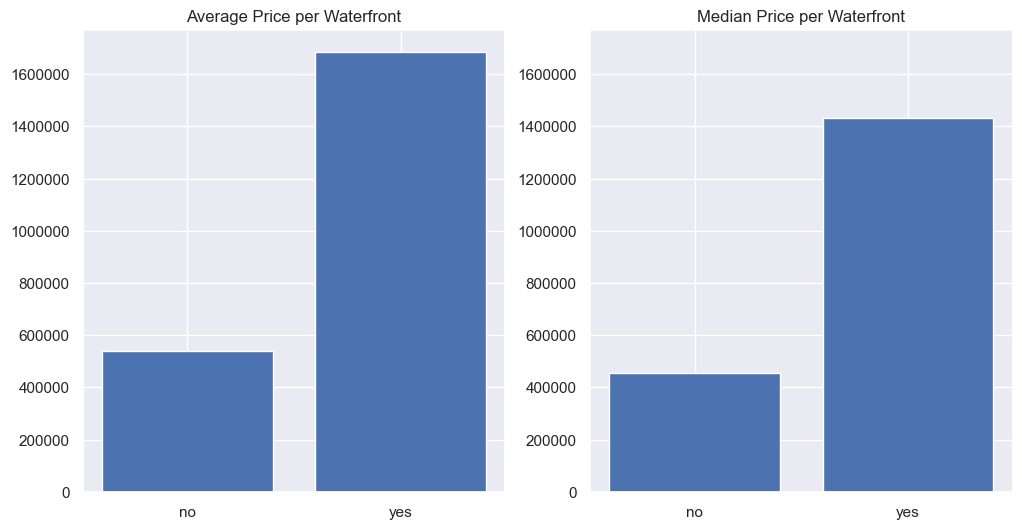

In [35]:
plot_bar(df_unique, 'waterfront', 'price')

In [36]:
mean_wf = df_unique.loc[df_unique['waterfront'] == 'yes'].price.mean()
mean_ = df_unique.loc[df_unique['waterfront'] == 'no'].price.mean()
((mean_ -mean_wf)/mean_)*100

-213.21734714042

The average price of properties with waterfront is 211,80% higher than the average price of properties without waterfront. 

**H2**: Properties built before 1965 are 50% cheaper, on average.

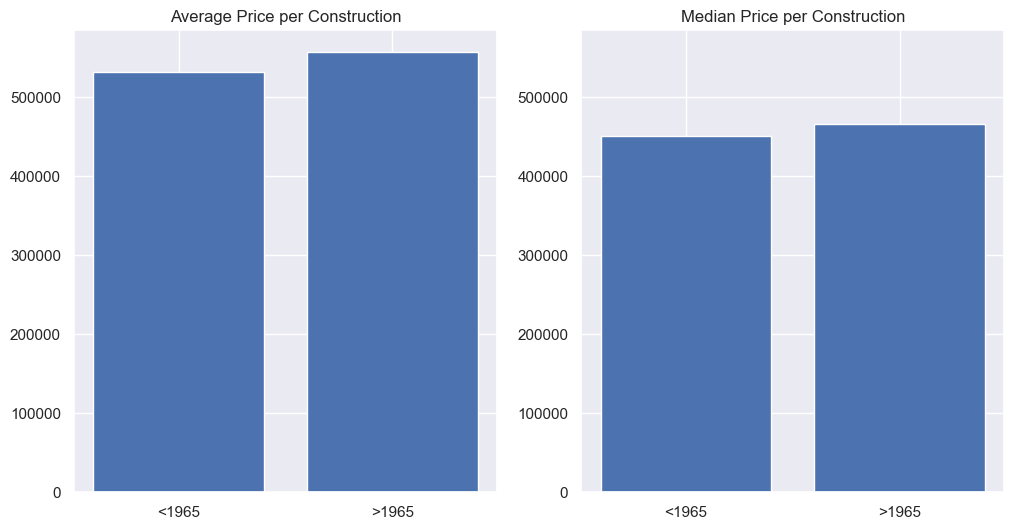

In [37]:
plot_bar(df_unique, cat='construction', cat_2='price')

In [38]:
mean_new = df_unique.loc[df_unique['construction'] == '>1965'].price.mean()
mean_old = df_unique.loc[df_unique['construction'] == '<1965'].price.mean()
((mean_old - mean_new)/mean_new)*100

-4.618012264255884

False. The constructions built before 1965 are only 4,62 % cheaper on average.

**H3**: Properties with basement are 30% more expensive. 

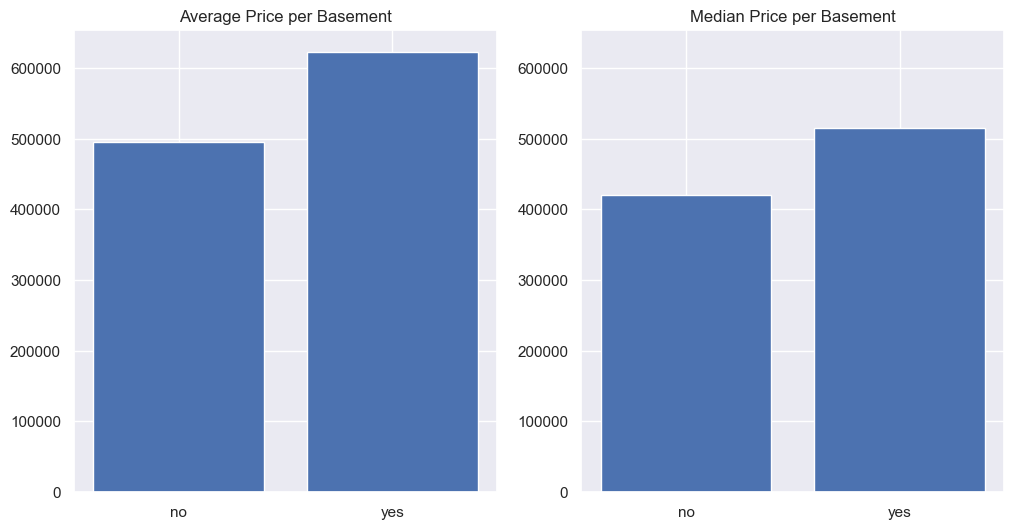

In [39]:
plot_bar(df_unique, cat='basement', cat_2='price')

In [40]:
mean_base = df_unique.loc[df_unique['basement'] == 'yes'].price.mean()
mean_ = df_unique.loc[df_unique['basement'] == 'no'].price.mean()
print(f'{((mean_base - mean_)/mean_):.2%}')

25.66%


**H4**: Properties that weren't renovated are 25% cheaper.

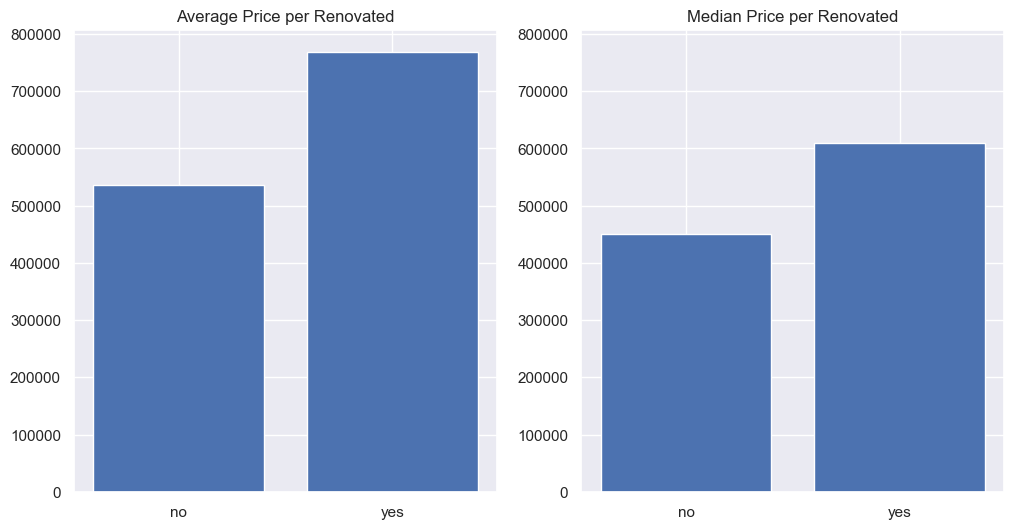

In [41]:
plot_bar(df_unique, cat='renovated', cat_2='price')

In [42]:
mean_renov = df_unique.loc[df_unique['renovated'] == 'yes'].price.mean()
mean_ = df_unique.loc[df_unique['renovated'] == 'no'].price.mean()
print(f'{((mean_ - mean_renov)/mean_renov):.2%}')

-30.17%


The average price of properties that weren't renovated is 30.17% lower than the average price of properties that were renovated.

**H5**: Constructions with 3 bathrooms have Month over Month growth of 15%.

In [43]:
df_3_bath = df_unique.loc[df_unique['bathrooms'] == 3]

# Average price of each month
df_month_price = df_3_bath[['date', 'price']].groupby(df_3_bath.date.dt.strftime('%Y-%m'),).mean(numeric_only=True)

# Average price of previous month
df_previous_month = df_3_bath[['date', 'price']].groupby(df_3_bath.date.dt.strftime('%Y-%m')).mean(numeric_only=True)
df_previous_month.loc['2014-04'] = 0.1
df_previous_month = df_previous_month.sort_index().drop('2015-05', axis=0)

#Plot data
plot_data = ((df_month_price.reset_index()['price'] - df_previous_month.reset_index()['price'])/df_previous_month.reset_index()['price'])*100
plot_data.index=df_month_price.index

plot_data = pd.concat([df_month_price , plot_data], axis=1, ignore_index=True).drop('2014-05', axis=0)
plot_data.rename(columns={0:'avg_price', 1:'growth %'}, inplace=True)


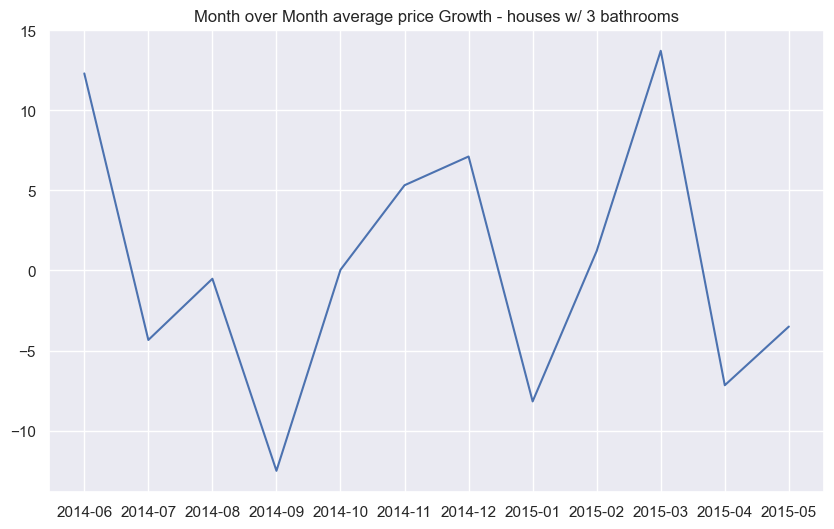

In [44]:
plt.figure(figsize=(10,6))
plt.title('Month over Month average price Growth - houses w/ 3 bathrooms')
plt.plot(plot_data.index, plot_data['growth %']);

False: the price growth over month was never above 15%.

**H6**: Properties with 3 or more bedrooms are 20% more expensive.

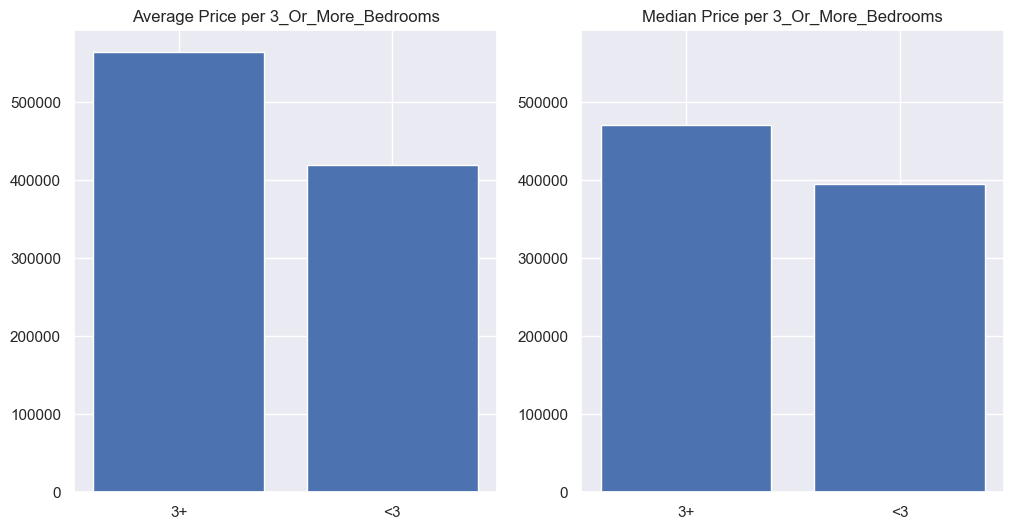

In [45]:
plot_bar(df_unique, cat='3_or_more_bedrooms', cat_2='price')

In [46]:
mean_3 = df_unique.loc[df_unique['3_or_more_bedrooms'] == '3+'].price.mean()
mean_ = df_unique.loc[df_unique['3_or_more_bedrooms'] == '<3'].price.mean()
print(f'{((mean_3 - mean_)/mean_):.2%}')

34.63%


On average, The buildings with 3 or more bedrooms are 34.63% more expensive than the other buildings. 

**H7**: Properties with low conditions (<=2) are 45% cheaper.

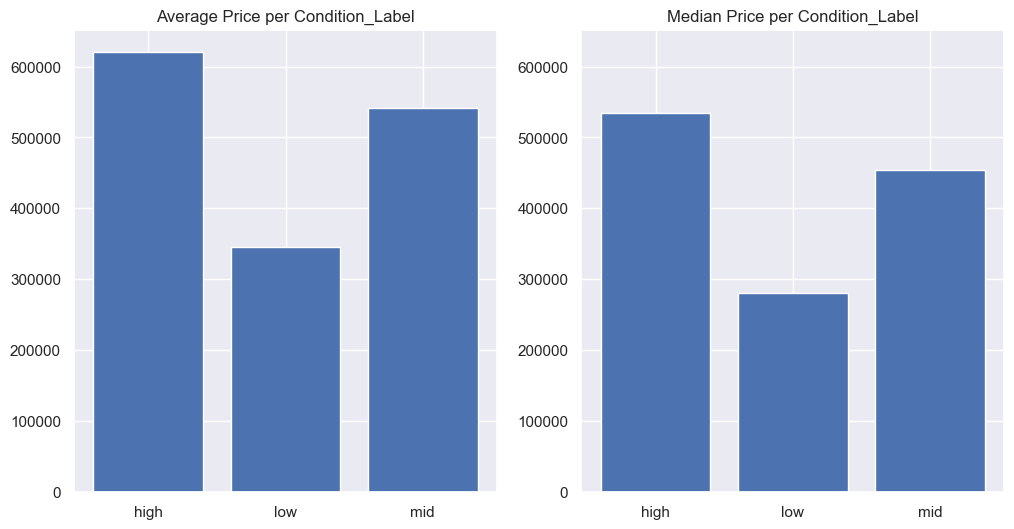

In [47]:
plot_bar(df_unique, cat='condition_label', cat_2='price')


In [48]:
mean_high = df_unique.loc[df_unique['condition_label'] == 'high'].price.mean()
mean_mid = df_unique.loc[df_unique['condition_label'] == 'mid'].price.mean()
mean_low = df_unique.loc[df_unique['condition_label'] == 'low'].price.mean()
print(f'{((mean_low - mean_high)/mean_high):.2%}')
print(f'{((mean_low - mean_mid)/mean_mid):.2%}')

-44.30%
-36.21%


Properties with low conditions are, on average, 44.30% cheaper than properties with high conditions; and 36.21% cheaper than properties with average conditions.

**H8**: The price of the properties with 3 or more 3 bedrooms is increasing.

In [49]:
df_8 = df_unique[['date', 'price', 'bedrooms']].query('bedrooms >= 3')
aux = df_8.groupby(df_8.date.dt.strftime('%Y-%m')).mean(numeric_only=True)

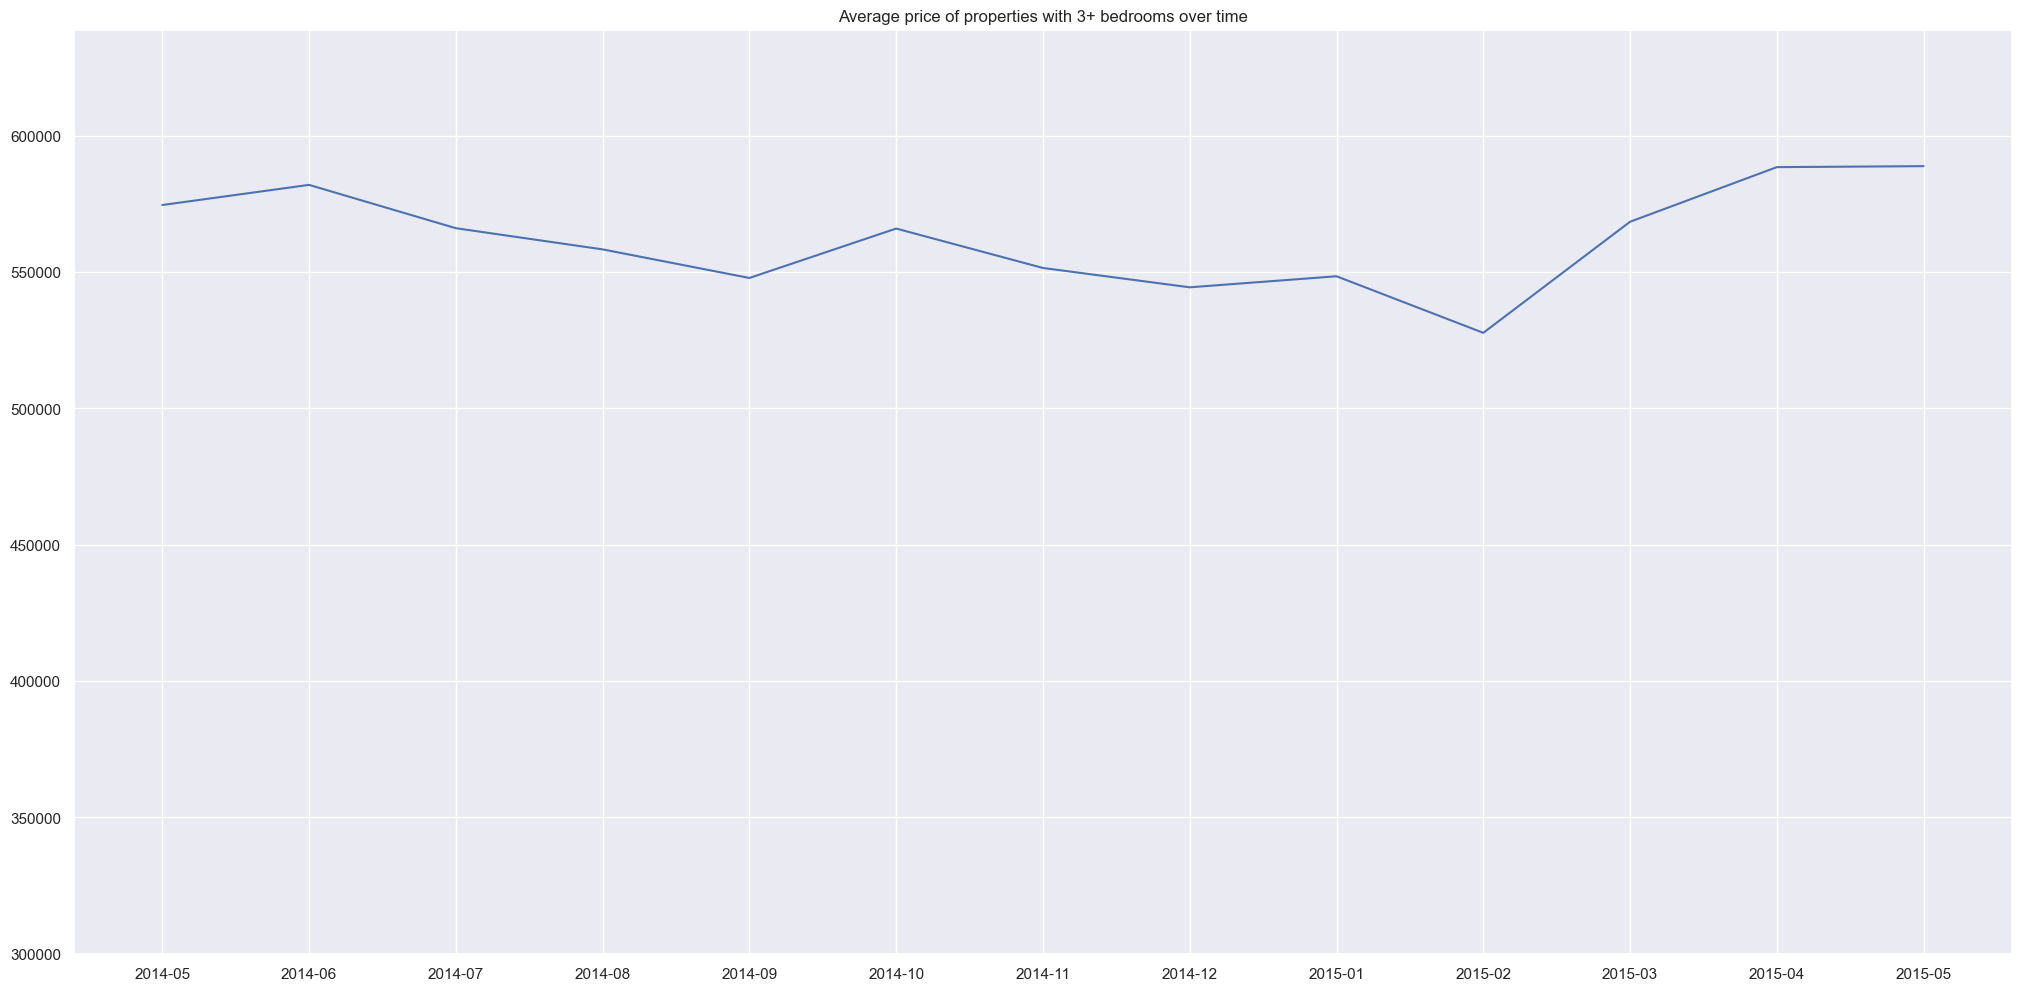

In [50]:
plt.plot(aux.index, aux.price)
plt.title('Average price of properties with 3+ bedrooms over time')
plt.ylim([300000, max(aux.price) + 50000]);

In the last few months we can see that the average price is increasing.

**H9**: Houses put on sale in the winter are cheaper.

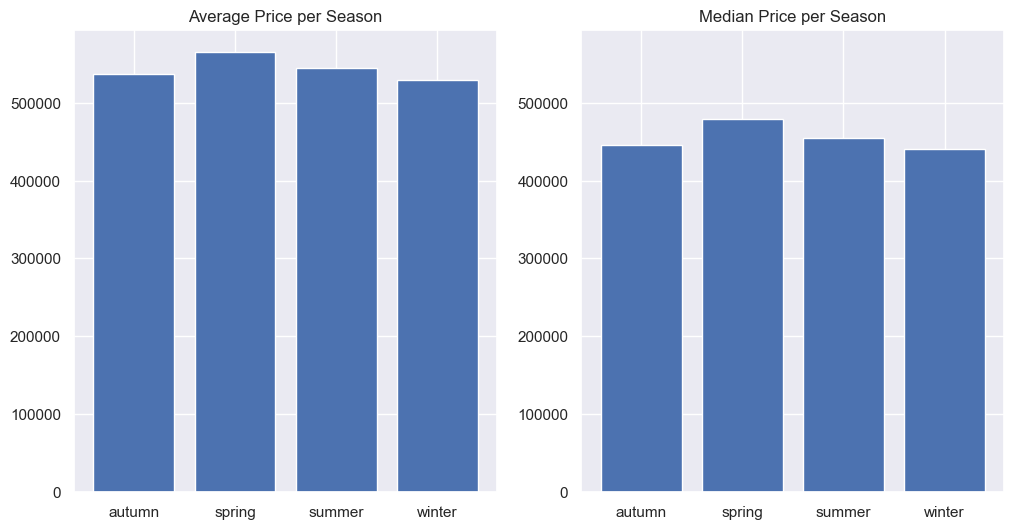

In [51]:
plot_bar(df_unique, cat='season', cat_2='price')

True: The average price of the properties put on sale during the winter is lower.

In [52]:
aux_1 = df_unique[['id', 'zipcode', 'date', 'bedrooms', 'bathrooms', 'm²_living', 'm²_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'm²_above', 'yr_built', 'yr_renovated', 'renovated', 'construction', 'condition_label', 'price', 'price/m²']]
aux_1 = aux_1.reset_index().drop('index', axis=1)
aux_1.loc[aux_1.renovated == 'yes', 'yr_built'] = aux_1['yr_renovated']

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 6.0. Adding the address information

Some properties didn't have the address information, so they will appear as Nan.

In [53]:
address = pd.read_csv('data_collect/address.csv')
address = address.drop_duplicates(subset='id', keep='last')
data = df_unique.merge( address, how='inner', on='id',)

In [54]:
data.head(5)

,id,date,price,bedrooms,bathrooms,m²_living,m²_lot,floors,waterfront,view,condition,grade,m²_above,m²_basement,yr_built,yr_renovated,zipcode,lat,long,m²_living15,m²_lot15,renovated,construction,3_or_more_bedrooms,basement,condition_label,price/m²,season,road,house_number,neighbourhood,county
0,7129300520,2014-10-13,221900.000,3,1.000,109.630,524.900,1.000,no,0,3,7,109.630,0.000,1955,0,98178,47.511,-122.257,124.490,524.900,no,<1965,3+,no,mid,2024.081,autumn,61st Avenue South,10012,Rainier Beach,King County
1,6414100192,2014-12-09,538000.000,3,2.250,238.760,672.800,2.000,no,0,3,7,201.600,37.160,1951,1991,98125,47.721,-122.319,157.010,709.690,yes,<1965,3+,yes,mid,2253.309,autumn,Northeast 127th Street,837,NaN,King County
2,2487200875,2014-12-09,604000.000,4,3.000,182.090,464.520,1.000,no,0,5,7,97.550,84.540,1965,0,98136,47.521,-122.393,126.350,464.520,no,>1965,3+,yes,high,3317.041,autumn,Fauntleroy Way Southwest,9231,Fauntleroy,King County
3,1954400510,2015-02-18,510000.000,3,2.000,156.080,750.660,1.000,no,0,3,8,156.080,0.000,1987,0,98074,47.617,-122.045,167.230,697.050,no,>1965,3+,no,mid,3267.555,winter,221st Avenue Northeast,901,NaN,King County
4,7237550310,2014-05-12,1225000.000,4,4.500,503.530,9469.600,1.000,no,0,3,11,361.390,142.140,2001,0,98053,47.656,-122.005,442.220,9469.600,no,>1965,3+,yes,mid,2432.824,spring,Northeast Patterson Way,25005,NaN,King County


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 7.0. Business Problem

1- Which houses should the company buy, and at what price?

The property will be recommended if the price is lower than the median price of the region, but only if the condition is above 1 and the grade is at least 6. That is because the construction with a condition lower than 2  will need a lot of repairs; and a grade lower than 6 means that it doesn't meet the building code.

In [55]:
# Finding the median prices by region and grade.
median_prices = data[['zipcode', 'grade', 'price']].groupby(['zipcode', 'grade']).median()
median_prices = median_prices.rename(columns={'price':'median_price'})
recom_data = data[['id', 'zipcode', 'road', 'house_number','grade', 'condition', 'price']]
recom_data = recom_data.merge(median_prices, how='left', on=['zipcode', 'grade'])

# Recommendation Column
recom_data['buy'] = recom_data.apply(lambda x: 'Yes' if ((x['grade'] > 6) and (x['condition'] >= 2) and (x['price'] < x['median_price'])) else 'No', axis=1)

# Recommended properties.
recom_props = recom_data.query('buy == "Yes"')

#### 7.1. Recommended price to pay

The recommended price will be calculated using the 70 rule which is a rule of thumb that is used to determine the maximum price to pay. First you calculate the  after renovation value (ARV) of the property and the repair costs. The maximum price will be given by the following formula:

- max_price = ARV *0.70 - repair_cost

Process to calculate the ARV:

1. Identify 3-6 comparable properties;

2. Calculate the average price per square foot of the comparables

3. Find the ARV by multiplying the average price per square foot of the comps by the investment property area

    ARV = Avg Cost m² of comps * investment area
    
    
4. Calculate the repair costs and find the maximum value.

#### 7.2. Costs Estimates

- **Light Rehab** -> $150.69/m². Properties that don't need a ton of major work done, but more the surface-level.

- **Medium Rehab** -> $279.86/m². More work is needed, require higher-quality materials, or both.

- **Heavy Rehab** -> $398.26/m². A lot of work is necessary and require top-notch materials.

- Closing Cost -> Costs to complete a real estate transaction (3 % of the purchase value).

https://www.dohardmoney.com/the-pros-guide-how-to-calculate-cost-on-a-fix-flip/

https://newsilver.com/the-lender/how-to-calculate-arv-simple-guide/

#### 7.3. Price to sell

The recommended price to sell will be the calculated ARV.

In [56]:
aux_data = data[['id', 'zipcode', 'road', 'house_number', 'waterfront','condition','bathrooms','floors','bedrooms','yr_built','grade','m²_above', 'date', 'm²_living', 'price', 'price/m²']]
aux_data.reset_index(drop='index', inplace=True)

In [57]:
# Creating a data frame with the recommend price and costs of each property.
df_aux = pd.DataFrame()
for id in recom_props.id:
    vals = property_report(id, aux_data)
    df_aux = pd.concat([df_aux, vals], axis=0, ignore_index=True)

# Merging the recommended properties with the calculated expected costs and the recommended price to pay.
recom_props = recom_props.merge(df_aux[['id', 'recom_price_to_pay', 'after_renovation_value', 'rehab_cost', 'closing_cost', 'comparables']], on='id', how='left')

# Properties with the price lower than the recommended price to pay plus 5%.
recom_props_most_profit = recom_props.query('1.05*recom_price_to_pay >= price').drop('buy', axis=1)

# Total cost
recom_props_most_profit['total_expected_cost'] = recom_props_most_profit['price'] + recom_props_most_profit['rehab_cost'] + recom_props_most_profit['closing_cost']

# Profit
recom_props_most_profit['profit'] = recom_props_most_profit['after_renovation_value'] - recom_props_most_profit['total_expected_cost'] 

# Only properties that have 3 or more comparables
recom_props_most_profit = recom_props_most_profit.query('comparables >= 3')

recom_props_most_profit.head()

,id,zipcode,road,house_number,grade,condition,price,median_price,recom_price_to_pay,after_renovation_value,rehab_cost,closing_cost,comparables,total_expected_cost,profit
2,2414600126,98146,Southwest 102nd Street,136,7,3,229500.000,325000.000,238775.236,407222.406,46280.448,7163.257,6,282943.705,124278.700
22,7231300125,98056,Blaine Avenue Northeast,659,8,4,345000.000,452500.000,427348.053,673494.249,44097.922,12820.442,4,401918.363,271575.886
28,1189001180,98122,27th Avenue,2717,7,3,425000.000,508500.000,407571.773,643902.545,43160.009,12227.153,4,480387.162,163515.383
29,3253500160,98144,22nd Avenue South,3214,7,5,317625.000,410000.000,573074.255,846374.644,19387.996,17192.228,6,354205.223,492169.420
36,4036801170,98008,Southeast 7th Street,16213,7,3,380000.000,490000.000,395186.045,629922.791,45759.909,11855.581,6,437615.490,192307.301


#### 7.4. Finding the most profitable way to invest the money.


In [58]:
# Filtering Columns
recom_props_final = recom_props_most_profit[['id', 'zipcode', 'road',	'house_number',	'grade', 'condition', 'after_renovation_value', 'total_expected_cost', 'profit']].rename(columns={'after_renovation_value': 'price_to_sell'})

In [59]:
recom_props_costprofit = pd.pivot_table(recom_props_final, values=['total_expected_cost','profit'], index=['id', 'zipcode'], aggfunc='sum')

In [68]:
# Getting the ids of the properties that will be the most profitable with the amount of investment at the disposal
np.random.seed(seed=42)
somas = []
iter_ids = {}
for n in range(0, 1000000):
    cumsum = np.cumsum(shuffle(recom_props_costprofit))
    sum_df = pd.DataFrame(cumsum)
    index = np.argmax(cumsum.total_expected_cost >= 120000000)
    properties = sum_df.iloc[0:index]
    #display(properties)
    soma = properties.iloc[index-1].profit
    if n == 0:
        somas.append(soma)
    elif soma > np.max(somas):
        somas.append(soma)
        iter_ids[n] = properties.reset_index().id

In [69]:
key = list(iter_ids.keys())[-1]
lista = iter_ids[key]
props_to_buy = recom_props_final.loc[recom_props_final.id.isin(lista)]

In [74]:
props_to_buy

,id,zipcode,road,house_number,grade,condition,price_to_sell,total_expected_cost,profit
2,2414600126,98146,Southwest 102nd Street,136,7,3,407222.406,282943.705,124278.700
28,1189001180,98122,27th Avenue,2717,7,3,643902.545,480387.162,163515.383
29,3253500160,98144,22nd Avenue South,3214,7,5,846374.644,354205.223,492169.420
36,4036801170,98008,Southeast 7th Street,16213,7,3,629922.791,437615.490,192307.301
41,1332700270,98056,Kennewick Place Northeast,2904,7,4,341992.401,244044.383,97948.018
...,...,...,...,...,...,...,...,...,...
8544,6056100165,98108,Martin Luther King Junior Way South,4065,7,3,313956.565,216652.975,97303.590
8990,1257201420,98103,North 60th Street,2318,9,3,1278556.421,715920.174,562636.247
9169,7896300592,98118,36th Avenue South,9235,8,3,764190.821,405042.942,359147.878
9226,263000009,98103,North 97th Street,925,8,3,605373.674,424029.328,181344.347


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 8.0. Financial Results

In [71]:
financial_result = pd.pivot_table(props_to_buy, values=['total_expected_cost','profit'], index=['id', 'zipcode'], aggfunc='sum', margins=True, margins_name='Total')
financial_result

,,profit,total_expected_cost
id,zipcode,,
13001215,98108,120803.184,150637.291
13001795,98108,253276.075,366463.819
126039413,98177,208165.999,552822.374
257000037,98168,163867.397,262416.843
263000009,98103,181344.347,424029.328
...,...,...,...
9818700320,98122,204949.459,557578.728
9826701794,98122,193369.085,442442.896
9828702890,98112,624880.327,832011.806


In [72]:
results = props_to_buy[['price_to_sell', 'total_expected_cost', 'profit']].sum()

total_profit = results.profit
total_costs = results.total_expected_cost
total_revenue = results.price_to_sell
roi = total_profit/total_costs*100

pd.DataFrame({'Investment': total_costs, 'Total Revenue': total_revenue, 'Total Profit': total_profit, 'ROI': roi}, index=[0]).T.rename(columns={0: 'Financial Result'})

,Financial Result
Investment,119748171.007
Total Revenue,183512805.532
Total Profit,63764634.525
ROI,53.249


### Conclusion

In this project, some nice insights were obtained through exploratory data analysis.
The insights helped to build two tables: the first with suggestions on what properties to buy and the second with the price to sell the properties after they were bought.